In [1]:
import matplotlib.pyplot as plt
import tqdm
from skimage.feature import hog
from skimage import data, exposure
from FDDB_dataloader import FDDB
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import torchvision.transforms as T
import numpy as np
import torch
import Model_zoo as Model
from queue import Queue
from IPython.display import display

### Method/Algorithm: Sliding Windows

* windows are with 1:1, 3:4, 9:16 ratio

* window is slided according to the sliding step/stride

* Non-Max Suppression is adopted: discard non-max pred && IoU>0.5

* Iteratively by resized range

In [2]:
class faceDetector(object):
    def __init__(self, backend):
        self.backend = backend
    
    def findFace(self, img, winSize, stride, preprocess, thres_score, thres_iou = 0.5, scales=[1.0,], anchors = [(1,1),]):
        img = img.copy()
        Iw, Ih = img.size
        stride = int(winSize * stride)
        Sw, Sh = stride if type(stride) == tuple else (stride, stride)
        results = []
        for r in scales:
            winSize = winSize * r
            for aw, ah in anchors:
                Bw, Bh = int(winSize), int(winSize / aw * ah)
                col = (Iw - Bw)//Sw + 1
                row = (Ih - Bh)//Sh + 1
#                 print(col, row, winSize, Sw, Sh)
                for c in range(col):
                    for r in range(row):
                        Tx, Ty = c*Sw, r*Sh
                        bndbox = np.array([Tx, Ty, Tx+Bw, Ty+Bh], dtype=int)
                        detectWin = img.crop(bndbox)
                        dataIn = preprocess(detectWin)
                        s_tmp = self.backend.get_score(dataIn)
                        if s_tmp > thres_score:
                            new_face = True
                            overlap = []
                            for i in range(len(results)):
                                iou, iouA, iouB = self.IoU(bndbox, results[i][1])
                                if iou > thres_iou or iouB > thres_iou or iouA > thres_iou:
                                    if s_tmp >= results[i][0]:
#                                         if len(overlap)==0:
#                                             results.append((s_tmp, bndbox))
                                        overlap.append(i)  
                                    else:
                                        new_face = False
                                        break
                            if new_face:
                                results.append((s_tmp,bndbox))
                            for k in range(len(overlap)):
                                results.pop(overlap[k]-k)
                                                      
        # Now we have the faces
        # Then Draw Bnd Boxes
        draw = ImageDraw.Draw(img)
        for _, bndbox in results:
            draw.line(bndbox[[0,1,2,1,2,3,0,3,0,1]].tolist(), fill='red')
        return results, img
                        
                    
    def IoU(self, boxA, boxB):
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        # compute the area of intersection rectangle
        interArea = (xB - xA + 1) * (yB - yA + 1)

        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        iouA = interArea / boxAArea
        iouB = interArea / boxBArea

        # return the intersection over union value
        return iou, iouA, iouB
        
        

## Testing

In [29]:
from skimage.feature import hog
import torchvision.transforms as T
hog_feature = lambda raw: hog(T.Resize((96,96))(raw), 
                  orientations=9, 
                  pixels_per_cell=(16,16,),
                  cells_per_block=(2,2),
                  block_norm = 'L2-Hys',
                  multichannel=True
                 )

In [30]:
import dill
with open('./Model_checkpoints/Logstics_SGD.pkl','rb') as fh:
    M = dill.load(fh)

In [49]:
D = faceDetector(M)

In [3]:
from FDDB_dataloader import FDDB
db = FDDB('train_list.npy',crop=False, zero_one=True)

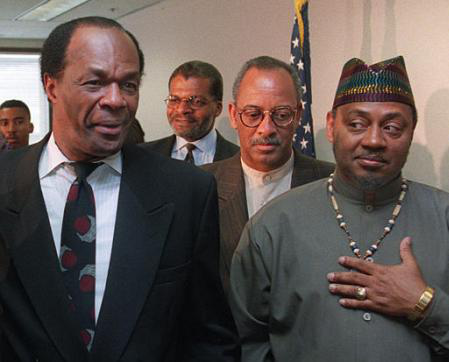

In [85]:
# img = db[5632][0] # 435, 666, 2333, 5632
img = Image.open('2002/08/13/big/img_1152.jpg') 
'''
    2002/08/10/big/img_144.jpg, 
    2002/08/10/big/img_600.jpg,
    2002/08/10/big/img_252.jpg,
    2002/08/13/big/img_1152.jpg
'''
img

In [69]:
db.datalist[18109]

['faces/2002/08/10/big/img_855_0.jpg', '5']

In [97]:
winSize = img.size[0]//9
stride = 0.3
scales =  [1.0, 1.5]
anchors= [(1,1),(3,4),(9,16)]
thres_score = 0.7
thres_iou = 0.7
f = D.findFace(img,winSize,stride,hog_feature,thres_score,thres_iou,scales, anchors)



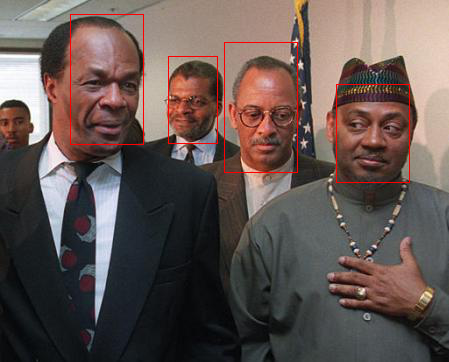

In [98]:
f[1]

In [78]:
f[0]

[(0.9878809762920745, array([189,   0, 324, 180])),
 (0.7816968160860377, array([ 27,  54, 162, 294]))]

In [141]:
import dill
with open('./Model_checkpoints/LDA.pkl','rb') as fh:
    M = dill.load(fh)

In [4]:
M = Model.CNN({
    'arch': 'resnet18',
    'epochs': 90,
    'optim': 'SGD',
    'save': True
})
M.load_checkpoint('checkpoint_resnet18_.pth.tar')
def prep(img):
    return M.img_trans(img).unsqueeze(0)

=> loading checkpoint 'checkpoint_resnet18_.pth.tar'
=> loaded checkpoint 'checkpoint_resnet18_.pth.tar' (epoch 90) as Teacher!


In [5]:
D = faceDetector(M)

[(tensor([14.2275]), array([ 72,  36, 135, 148])), (tensor([13.1754]), array([204,  24, 267, 136])), (tensor([6.6918]), array([240, 144, 303, 256])), (tensor([3.5551]), array([300, 108, 363, 220]))]


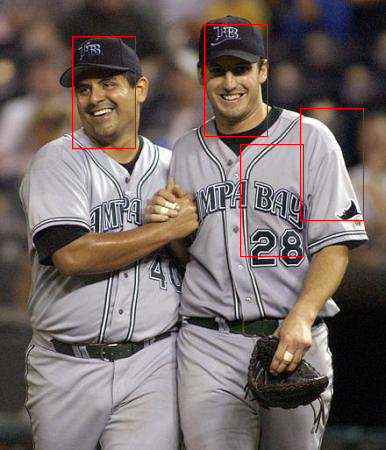

[(tensor([5.7776]), array([360, 180, 435, 313])), (tensor([17.3234]), array([180,   0, 330, 200])), (tensor([15.8536]), array([ 15,  15, 165, 281]))]


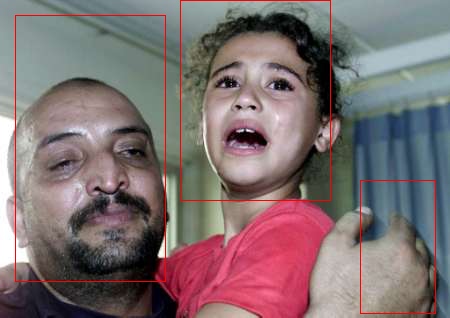

[(tensor([8.3800]), array([210,  75, 285, 150])), (tensor([10.0764]), array([ 75,  15, 150, 115])), (tensor([14.1580]), array([300,  15, 375, 115])), (tensor([4.8954]), array([345, 105, 420, 238]))]


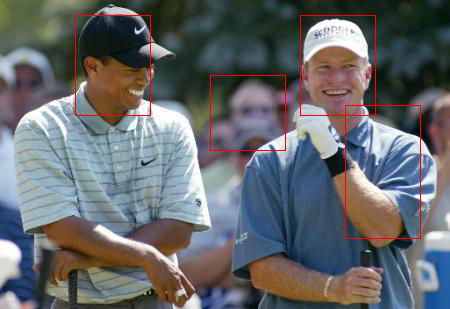

[(tensor([13.7789]), array([224,  70, 297, 168])), (tensor([15.5913]), array([336,  56, 409, 186])), (tensor([13.0915]), array([ 28,   0, 175, 147]))]


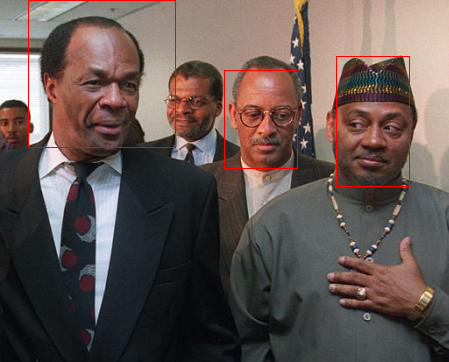

In [10]:
# img = db[5632][0] # 
# img_list = [435, 666, 2333, 5632]
img_list = [
    '2002/08/10/big/img_144.jpg', 
    '2002/08/10/big/img_600.jpg',
    '2002/08/10/big/img_252.jpg',
    '2002/08/13/big/img_1152.jpg']
for i in img_list:
#     img = db[i][0]
    img = Image.open(i)
    winSize = img.size[0]//9 #9 #3
    stride = 0.3 #0.3 # 2
    scales =  [1.0, 1.5, 2.0]
    anchors= [(1,1),(3,4),(9,16)]
    thres_score = 0.
    thres_iou = 0.1
    res, d_img = D.findFace(img,winSize,stride,prep,thres_score,thres_iou,scales, anchors)
    print(res)
    display(d_img)




In [103]:
D.IoU([ 93, 124, 250, 404],[124,  62, 281, 342])

(0.4560779233556893, 0.626447137258435, 0.626447137258435)

In [89]:
z = img.copy()

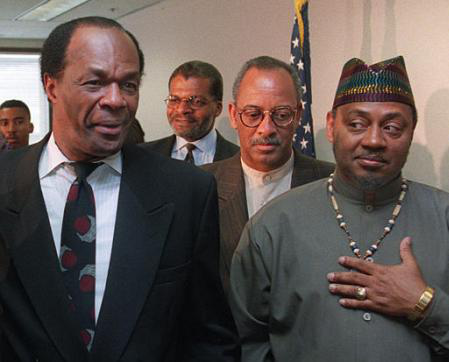

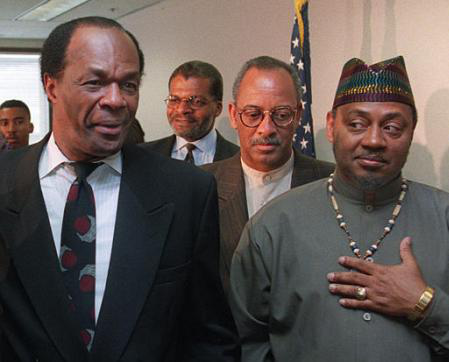

In [96]:
display(z)
display(img)

In [112]:
a = [0,1,2,3]

In [123]:
a.pop(2)
a

[0, 1]

In [115]:
qq.put(0)

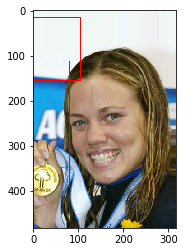